# Dataset for MSR 2019 (data showcase paper)

This notebook covers the data preparation phase, including the following steps:

* fetching the content of the Vulas DB from the Vulas backend (or from a local file, where it has been previously saved)
* fixing the content of the DB to correct GIT repositories that have been moved (SVN repos are ignored)
* ensuring that each GIT repository that appears in the Vulas DB is cloned locally
* expand the dataset with negative examples (annotated as 'neg')
* creating a dataframe that contains the full annotated dataset
* storing the dataframe in a binary (pickle) file


## Prerequisites

In [1]:
# This points to the dataset CSV file (leave out the '_release.csv' suffix!)
VULAS_DB_NAME='../dataset/vulas_db_msr2019'

GIT_REPO_FOLDER = '/tmp/git-cache-3'
SKIP_CLONE_EXISTING=True

# This controls how many negatives you want per each positive
RATIO_POS_NEG = 1
DATASET_NAME='dataset_msr2019'

In [14]:
%reload_ext autoreload
%autoreload 2

import os
import sys; sys.path.append(os.path.join(sys.path[0],'acacia'))
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np

import requests
import requests_cache
requests_cache.install_cache('requests_cache', expire_after=7 * 24*60*60)

# acacia stuff
from utils import *
from acacia.git import clone_repo, clone_repo_multiple, extract_commit_msg, extract_commit_diff, get_random_commits
from acacia.git_temporal import extract_timing_data

POS_CLS='pos'
NEG_CLS='neg'

In [4]:
le = LatexExporter()

## Load dataset from CSV file

In [5]:
with open(VULAS_DB_NAME + '_release.csv','r') as f:
    data = f.readlines()

vulas_db_content=[]
for d in data:
    line = d.strip().split(',')
    vulas_db_content.append(tuple(line))

# len(vulas_db_content)
print('Dataset contains {} commits'.format(len(vulas_db_content)))

Dataset contains 1282 commits


### Cloning

This clones locally all (external git) repositories that appear in the Vulas DB.

In [6]:
repos_set = set([ r for _,r,_,_ in vulas_db_content ])
clone_repo_multiple(repos_set,
       output_folder=GIT_REPO_FOLDER,
       proxy='',
       skip_existing=SKIP_CLONE_EXISTING,
       concurrent=8)

## Storing commit data in a dataframe (positive instances)

In [53]:
def extract_commit(db_content, verbose=False):
    ''' return a dataframe with commit data '''
    data = []
    for vuln_id, repo, commit, cls in tqdm(db_content):
        try:
            commit_msg = extract_commit_msg(commit, repo, GIT_REPO_FOLDER) 
            commit_diff = extract_commit_diff(commit, repo, GIT_REPO_FOLDER)
            fix_tag, fix_tag_timestamp, commit_timestamp, commit_tag_delay = extract_timing_data(commit, repo, verbose, GIT_REPO_FOLDER)
            data.append({
                'msg' : commit_msg.decode("latin-1"),
                'diff': commit_diff.decode("latin-1"),
                'cls': cls,
                'commit_id': commit,
                'repo_url': repo,
                'vuln_id': vuln_id,
                'in_nvd': False,
                'fix_tag': fix_tag,
                'fix_tag_timestamp': int(fix_tag_timestamp),
                'commit_timestamp' : int(commit_timestamp),
                'commit_tag_delay': int(commit_tag_delay)
            })
        except Exception as e:
            pass
            print('Skipping %s' % repo)
            print(e)

    return pd.DataFrame(data)

df_pos = extract_commit(vulas_db_content, verbose=False)
df_pos.to_pickle(DATASET_NAME + '_pos.pd')

  0%|          | 1/1282 [00:00<08:58,  2.38it/s]

('v2.4.5.RELEASE', '1496240700', '1496240700', 0)


  0%|          | 2/1282 [00:00<08:57,  2.38it/s]

('4.0.5', '1521443138', '1520616563', 826575)


  0%|          | 3/1282 [00:01<13:18,  1.60it/s]

('camel-2.16.5', '1481903857', '1481744113', 159744)


  0%|          | 4/1282 [00:02<15:45,  1.35it/s]

('jenkins-2.84', '1507571749', '1505309456', 2262293)


  0%|          | 5/1282 [00:03<15:42,  1.35it/s]

('TOMCAT_9_0_9', '1529499958', '1529350518', 149440)


  0%|          | 6/1282 [00:04<16:02,  1.33it/s]

('TOMCAT_8_5_10', '1483656695', '1481713005', 1943690)


  1%|          | 7/1282 [00:05<15:16,  1.39it/s]

('TOMCAT_5_5_29', '1269869757', '1264878855', 4990902)


  1%|          | 8/1282 [00:06<16:39,  1.27it/s]

('v2.1.2', '1506970635', '0', 0)


  1%|          | 9/1282 [00:07<16:41,  1.27it/s]

('TOMCAT_8_0_0_RC2', '1379434016', '1378907061', 526955)


  1%|          | 10/1282 [00:07<16:30,  1.28it/s]

('TOMCAT_9_0_0_M1', '1447365794', '1398424255', 48941539)


  1%|          | 11/1282 [00:08<16:47,  1.26it/s]

('rel/release-2.3.4', '1541020751', '1540451552', 569199)


  1%|          | 12/1282 [00:09<16:28,  1.28it/s]

('3.6.9', '1492740314', '1492722956', 17358)


  1%|          | 13/1282 [00:10<17:19,  1.22it/s]

('v4.3.17.RELEASE', '1525765700', '1523938812', 1826888)


  1%|          | 14/1282 [00:11<17:36,  1.20it/s]

('TOMCAT_8_0_39', '1478591933', '1478089115', 502818)


  1%|          | 15/1282 [00:12<17:09,  1.23it/s]

('r1rv57', '1494568533', '1476490865', 18077668)


  1%|          | 16/1282 [00:13<17:28,  1.21it/s]

('camel-2.13.0', '1395064468', '1389345479', 5718989)


  1%|▏         | 17/1282 [00:14<17:24,  1.21it/s]

('jackson-databind-2.9.0', '1501388466', '1498840213', 2548253)


  1%|▏         | 18/1282 [00:14<17:22,  1.21it/s]

('1.0.0-rc0', '1507682601', '1504197728', 3484873)


  1%|▏         | 19/1282 [00:15<17:02,  1.23it/s]

('STRUTS_2_3_14_3', '1370251048', '1370249236', 1812)


  2%|▏         | 20/1282 [00:15<16:45,  1.26it/s]

('2.7.4.14', '1492544092', '1492541356', 2736)


  2%|▏         | 21/1282 [00:17<17:09,  1.22it/s]

('TOMCAT_7_0_23', '1321552355', '1320654402', 897953)


  2%|▏         | 22/1282 [00:17<17:09,  1.22it/s]

('TOMCAT_9_0_0_M10', '1472655568', '1472597729', 57839)


  2%|▏         | 23/1282 [00:19<17:42,  1.19it/s]

('cxf-3.0.13', '1491421812', '1483115370', 8306442)


  2%|▏         | 24/1282 [00:20<17:35,  1.19it/s]

('5.2.5.Final', '1489589716', '1406098929', 83490787)


  2%|▏         | 25/1282 [00:21<17:45,  1.18it/s]

('camel-2.17.5', '1484689776', '1481278509', 3411267)


  2%|▏         | 26/1282 [00:22<17:43,  1.18it/s]

('REL_3_11_BETA1', '1406832992', '1392854086', 13978906)


  2%|▏         | 27/1282 [00:22<17:32,  1.19it/s]

('esapi-2.1.0', '1378171007', '1377737381', 433626)


  2%|▏         | 28/1282 [00:23<17:22,  1.20it/s]

('rel/release-2.3.3', '1522280789', '1520033796', 2246993)


  2%|▏         | 29/1282 [00:24<17:19,  1.21it/s]

('wicket-jquery-ui-6.28.1', '1514413771', '1514389926', 23845)


  2%|▏         | 30/1282 [00:24<17:06,  1.22it/s]

('5.2.5.Final', '1489589716', '1406103198', 83486518)


  2%|▏         | 31/1282 [00:25<17:04,  1.22it/s]

('v2.7.1', '1498849106', '1454384221', 44464885)


  2%|▏         | 32/1282 [00:25<16:53,  1.23it/s]

('REL_3_17_BETA1', '1498296431', '1493767933', 4528498)


  3%|▎         | 33/1282 [00:26<16:53,  1.23it/s]

('activemq-5.11.3', '1446127007', '1446039209', 87798)


  3%|▎         | 34/1282 [00:27<16:40,  1.25it/s]

('shiro-root-1.3.2', '1473457952', '1473452817', 5135)


  3%|▎         | 35/1282 [00:29<17:23,  1.19it/s]

('', '0', '1527063620', -1527063620)


  3%|▎         | 36/1282 [00:30<17:27,  1.19it/s]

('jenkins-2.89', '1509992125', '1508429691', 1562434)


  3%|▎         | 37/1282 [00:30<17:20,  1.20it/s]

('TOMCAT_7_0_23', '1321552355', '1319904978', 1647377)


  3%|▎         | 38/1282 [00:31<17:06,  1.21it/s]

('3.20.0', '1496950449', '1496948452', 1997)


  3%|▎         | 39/1282 [00:32<17:05,  1.21it/s]

('1.565.1-rc1', '1401243057', '1392146256', 9096801)


  3%|▎         | 40/1282 [00:32<16:53,  1.23it/s]

('1.18-RC1', '1534144445', '1533839963', 304482)


  3%|▎         | 41/1282 [00:33<16:44,  1.23it/s]

('', '0', '1237993876', -1237993876)


  3%|▎         | 42/1282 [00:33<16:37,  1.24it/s]

('TOMCAT_7_0_42', '1372751619', '1299673258', 73078361)


  3%|▎         | 43/1282 [00:34<16:21,  1.26it/s]

('', '0', '1432206700', -1432206700)


  3%|▎         | 44/1282 [00:34<16:16,  1.27it/s]

('TOMCAT_9_0_0_M19', '1490613205', '1490388680', 224525)


  4%|▎         | 45/1282 [00:35<16:08,  1.28it/s]

('gerrit-trigger-2.27.5', '1519212287', '1519209107', 3180)


  4%|▎         | 46/1282 [00:35<15:57,  1.29it/s]

('XSTREAM_1_4_9', '1458083383', '1444153038', 13930345)


  4%|▎         | 47/1282 [00:36<15:49,  1.30it/s]

('3.1.6.RELEASE', '1394486792', '1394480639', 6153)


  4%|▎         | 48/1282 [00:37<15:52,  1.30it/s]

('camel-2.18.3', '1488999888', '1488179099', 820789)


  4%|▍         | 49/1282 [00:37<15:42,  1.31it/s]

('3.3.0.3', '1469040744', '1462308206', 6732538)


  4%|▍         | 50/1282 [00:37<15:32,  1.32it/s]

('STRUTS_2_3_16', '1385807266', '1373875343', 11931923)


  4%|▍         | 51/1282 [00:38<15:21,  1.34it/s]

('', '0', '1364568129', -1364568129)


  4%|▍         | 52/1282 [00:39<15:24,  1.33it/s]

('camel-2.17.6', '1488709476', '1488179471', 530005)


  4%|▍         | 53/1282 [00:39<15:15,  1.34it/s]

('STRUTS_2_3_14_3', '1370251048', '1370249180', 1868)


  4%|▍         | 54/1282 [00:39<15:08,  1.35it/s]

('1.3.0', '1442614234', '1440632109', 1982125)


  4%|▍         | 55/1282 [00:40<15:06,  1.35it/s]

('TOMCAT_7_0_53', '1395716435', '1395059699', 656736)


  4%|▍         | 56/1282 [00:41<15:17,  1.34it/s]

('6.0.0.Alpha3', '1530696485', '1529917573', 778912)


  4%|▍         | 57/1282 [00:42<15:08,  1.35it/s]

('', '0', '1395694514', -1395694514)


  5%|▍         | 58/1282 [00:42<15:03,  1.36it/s]

('email-ext-2.57.1', '1490023083', '1485208614', 4814469)


  5%|▍         | 59/1282 [00:43<14:55,  1.37it/s]

('', '0', '1437641386', -1437641386)


KeyboardInterrupt: 

In [7]:
df_pos = pd.read_pickle(DATASET_NAME + '_pos.pd')
if len(vulas_db_content) - len(df_pos.index) != 0:
    print('There where ' + str(len(vulas_db_content)- len(df_pos.index))  + ' commits that could not be processed')
print('Successfully processed ' + str(len(df_pos.index)) + ' (pos) commits.')
df_pos.head()

Successfully processed 1282 (pos) commits.


,cls,commit_id,commit_tag_delay,commit_timestamp,diff,fix_tag,fix_tag_timestamp,in_nvd,msg,repo_url,vuln_id
0,pos,57f2ccb66946943fbf3b3f2165eac1c8eb6b1523,0,1496240700,diff --git a/spring-webflow/src/main/java/org/...,v2.4.5.RELEASE,1496240700,False,Use fixed parser for empty value binding expre...,https://github.com/spring-projects/spring-webflow,CVE-2017-4971
1,pos,8471904a02438c03965d21367890276bc25fa5a6,826575,1520616563,diff --git a/docs/release-notes.html b/docs/re...,4.0.5,1521443138,False,Fix a SimpleBindRequest bug\n,https://github.com/pingidentity/ldapsdk,CVE-2018-1000134
2,pos,57d01e2fc8923263df896e9810329ee5b7f9b69,159744,1481744113,diff --git a/components/camel-jackson/src/main...,camel-2.16.5,1481903857,False,CAMEL-10567: Camel-Jackson: Add an option to a...,https://github.com/apache/camel,CVE-2016-8749
3,pos,d7ea3f40efedd50541a57b943d5f7bbed046d091,2262293,1505309456,diff --git a/core/src/main/java/hudson/slaves/...,jenkins-2.84,1507571749,False,[SECURITY-478] Require RUN_SCRIPTS before conf...,https://github.com/jenkinsci/jenkins/,CVE-2017-1000393
4,pos,2835bb4e030c1c741ed0847bb3b9c3822e4fbc8a,149440,1529350518,diff --git a/java/org/apache/tomcat/websocket/...,TOMCAT_9_0_9,1529499958,False,Enable host name verification for secure WebSo...,https://github.com/apache/tomcat/,CVE-2018-8034


[FIXBELOWHANDREDDAYS] Number of fix commits released in less than 100 days: 817
[FIXBELOWONEDAYS] Number of fix commits released in less than 1 days: 181
[FIXNOTRELEASED] Number of fix commits not released: 0


Text(0,0.5,'# Commits')

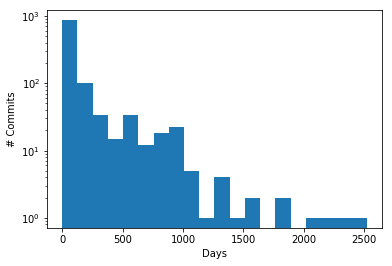

In [8]:
df_pos['days']=df_pos[df_pos['commit_tag_delay'] > 0]['commit_tag_delay']/(3600*24)

df1=df_pos[df_pos['commit_tag_delay'] > 0]['commit_tag_delay']/(3600*24)

 

df2=df1.to_frame()

 

le.save('FIXBELOWHANDREDDAYS', len(df2[(df2['commit_tag_delay']).round()<100]), 'Number of fix commits released in less than 100 days')

le.save('FIXBELOWONEDAYS', (len(df2[(df2['commit_tag_delay']).round() <1 ]) ), 'Number of fix commits released in less than 1 days')

le.save('FIXNOTRELEASED', len(df_pos[df_pos['days']==np.nan]), 'Number of fix commits not released')

 

d = {'Days': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,500,1000,2000 ],
     '# Commits': [len(df2[df2['commit_tag_delay'].round()<1]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=1])&len(df2[df2['commit_tag_delay'].round()<2]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=2])&len(df2[df2['commit_tag_delay'].round()<3]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=3])&len(df2[df2['commit_tag_delay'].round()<4]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=4])&len(df2[df2['commit_tag_delay'].round()<5]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=5])&len(df2[df2['commit_tag_delay'].round()<6]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=6])&len(df2[df2['commit_tag_delay'].round()<7]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=7])&len(df2[df2['commit_tag_delay'].round()<8]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=8])&len(df2[df2['commit_tag_delay'].round()<9]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=9])&len(df2[df2['commit_tag_delay'].round()<10]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=10])&len(df2[df2['commit_tag_delay'].round()<11]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=11])&len(df2[df2['commit_tag_delay'].round()<12]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=12])&len(df2[df2['commit_tag_delay'].round()<13]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=13])&len(df2[df2['commit_tag_delay'].round()<14]),

                                                                   len(df2[df2['commit_tag_delay'].round()>=14])&len(df2[df2['commit_tag_delay'].round()<15]),

                                                                 len(df2[df2['commit_tag_delay'].round()>=15])&len(df2[df2['commit_tag_delay'].round()<50]),

                                                                 len(df2[df2['commit_tag_delay'].round()>=50])&len(df2[df2['commit_tag_delay'].round()<100]),

                                                                 len(df2[df2['commit_tag_delay'].round()>=100])&len(df2[df2['commit_tag_delay'].round()<500]),

                                                                 len(df2[df2['commit_tag_delay'].round()>=500])&len(df2[df2['commit_tag_delay'].round()<1000]),

                                                                 len(df2[df2['commit_tag_delay'].round()>=1000])&len(df2[df2['commit_tag_delay'].round()<2000])

                                                                  ]}

df = pd.DataFrame(data=d)

   

with open('msr2019/tex/delays'+'.tex','w') as tf:

        tf.write(df.to_latex(columns=['Days','# Commits'],index=False, column_format='lc'))

   

 

plt.savefig('msr2019/img/commitTagDelay'+'.pdf', dpi=200, bbox_inches='tight')
matplotlib.pyplot.hist(df1.round(),bins=20,log=True,histtype='bar')
matplotlib.pyplot.xlabel("Days")
matplotlib.pyplot.ylabel("# Commits")

## Create deduplicated version of (pos) dataset

Deduplication is based on the equality of commit messages.

In [15]:
# count duplicates

dup_idx = df_pos.duplicated(subset='msg')
dup_commit_count = dup_idx.value_counts()[1]
print('There are {} duplicate commits out of {}'.format(dup_commit_count, len(df_pos.index)))

le.save('DUPLICATECOMMITSCOUNT', dup_commit_count, 'Number of duplicate commits')

There are 420 duplicate commits out of 1282
[DUPLICATECOMMITSCOUNT] Number of duplicate commits: 420


In [16]:
df_pos_dedup = df_pos.drop_duplicates(subset='msg')
df_pos[df_pos.duplicated(subset='msg')].vuln_id.nunique()
# df_pos_dedup.vuln_id.nunique()
df_pos[dup_idx].sort_values('msg')

,cls,commit_id,commit_tag_delay,commit_timestamp,diff,fix_tag,fix_tag_timestamp,in_nvd,msg,repo_url,vuln_id,days
763,pos,dc4c3317452f0bc2c5e1f6a08d3bd9f22488b450,126207,1472597786,diff --git a/java/org/apache/catalina/realm/Da...,TOMCAT_8_0_37,1472723993,False,Make timing attacks against the Realm impleme...,https://github.com/apache/tomcat80,CVE-2016-0762,1.460729
330,pos,d79c63d424fe6b225678416343b9ce106dec947c,75177,1472597763,diff --git a/java/org/apache/catalina/realm/Da...,TOMCAT_8_5_5,1472672940,False,Make timing attacks against the Realm impleme...,https://github.com/apache/tomcat85,CVE-2016-0762,0.870104
1263,pos,458e511ce2f2b47fd216f68c0e385fc06a5f1d2f,4188007,1380253020,diff --git a/jetty-util/src/main/java/org/ecli...,jetty-9.0.x,1384441027,False,418014 Handle NTFS canonical exceptions during...,https://github.com/eclipse/jetty.project,PT-2013-65,48.472303
515,pos,4df5647f6dfdc5fa7abb812afe9290d60b17c098,50530587,1424727893,diff --git a/jetty-http/src/main/java/org/ecli...,jetty-9.3.13.M0,1475258480,False,460642 - HttpParser error 400 can expose previ...,https://github.com/eclipse/jetty.project,CVE-2015-2080,584.844757
1264,pos,d2e49be3a8f21d862726c1f6bc9e1caa6ee8b58,4665600,1512567732,diff --git a/activemq-client/src/main/java/org...,activemq-5.15.3,1517233332,False,AMQ-6871 - By default only send generic platfo...,https://github.com/apache/activemq,CVE-2017-15709,54.000000
537,pos,8ff18c5e254bf43395f2e0d7e3a1092b33ec646,-1512567766,1512567766,diff --git a/activemq-client/src/main/java/org...,,0,False,AMQ-6871 - By default only send generic platfo...,https://github.com/apache/activemq,CVE-2017-15709,NaN
824,pos,4150f107e60cac4a7735fcf7cb4c1889a0cbab6,774010,1458075612,diff --git a/spring-amqp/src/main/java/org/spr...,v1.5.5.RELEASE,1458849622,False,AMQP-590: Java Deserialization White List\n,https://github.com/spring-projects/spring-amqp,AMQP-590,8.958449
832,pos,462dcb6f1f93d54923daffb9729c1c8519576c08,773273,1458075370,diff --git a/spring-amqp/src/main/java/org/spr...,v1.6.0.M2,1458848643,False,AMQP-590: Java Deserialization White List\n,https://github.com/spring-projects/spring-amqp,AMQP-590,8.949919
1145,pos,83fe9fdec2c86a57898d56c5e109debd9d5c07d,168717,1504711070,diff --git a/spring-amqp/src/main/java/org/spr...,v1.5.7.RELEASE,1504879787,False,AMQP-766: Deserialization in Message.toString()\n,https://github.com/spring-projects/spring-amqp,CVE-2017-8045,1.952743
1102,pos,6e9e00bb5bf0aa88444146db3c2eae138cc7b0a,168550,1504710986,diff --git a/spring-amqp/src/main/java/org/spr...,v1.6.11.RELEASE,1504879536,False,AMQP-766: Deserialization in Message.toString()\n,https://github.com/spring-projects/spring-amqp,CVE-2017-8045,1.950810


In [17]:
le.save('DATASETSIZEPOS', len(df_pos.index), 'Number of \'pos\' commits in the dataset (this includes duplicates!)' )
le.save('DATASETSIZEPOSDEDUP', len(df_pos_dedup), 'Number of pos commits, **de-duplicated**')
# le.print()

[DATASETSIZEPOS] Number of 'pos' commits in the dataset (this includes duplicates!): 1282
[DATASETSIZEPOSDEDUP] Number of pos commits, **de-duplicated**: 862


## Expand dataset with 'negative' instances

In [ ]:
# import pandas as pd
# from acacia.git import *
# # from acacia.dataset import *
# from tqdm import tqdm

import random
RND_SEED=17534532

def expand_dataset(repos_set, df_pos):
    neg_instances = []
    SEC_REGEXP = '(denial.of.service|XXE|remote.code.execution|open.redirect|osvdb|secur.+|vuln.+|exploit.+|malicious.*|attack.*|dos|directory.traversal|injection|cve-\d+-\d+|xss|nvd|cross.site|csrf|rce|clickjack|session.fixation|advisory|insecur.+|cross.origin|unauthori[z|s].+)'

    for repo in tqdm(repos_set):
        count = len(df_pos.loc[df_pos['repo_url'] == repo])
        commits = get_random_commits(int(count * RATIO_POS_NEG), repo, GIT_REPO_FOLDER)
        for c in commits:
            try:
                new_instance = {}
                commit_msg = extract_commit_msg(c, repo, GIT_REPO_FOLDER)
                commit_diff = extract_commit_diff(c, repo, GIT_REPO_FOLDER) 
                if re.match(SEC_REGEXP, commit_msg.decode("utf-8")):
                    print('Found match of SEC_REGEXP in NEG instance')
                    print(commit_msg)

                new_instance = {
                    'msg' : commit_msg.decode("latin-1") ,
                    'diff': commit_diff.decode("latin-1") ,
                    'cls': 'neg',
                    'commit_id': c,
                    'repo_url': repo ,
                    'vuln_id' : '',
                    'in_nvd': False,
                    'fix_tag': '',
                    'fix_tag_timestamp': 0,
                    'commit_timestamp' : 0,
                    'commit_tag_delay': 0
                }
                neg_instances.append(new_instance)
            except Exception as e:
                print('There was an exception with this commit, skipping: %s:%s' % (repo,c) )
                print(e)
    return pd.DataFrame(neg_instances)

random.seed(RND_SEED)
df_neg = expand_dataset(repos_set,df_pos_dedup)


 31%|███       | 75/243 [02:18<05:09,  1.84s/it]

In [ ]:
df_neg = pd.DataFrame()
df_all = pd.concat([df_pos_dedup, df_neg], ignore_index = True)
overall_size = len(df_all.index)
print('The dataset contains '+ str(overall_size) + ' commits')

## Persist dataset

### Pickle

In [ ]:
df_all.to_pickle(DATASET_NAME + '_all.pd')
df_pos.to_pickle(DATASET_NAME + '_pos.pd')
df_pos_dedup.to_pickle(DATASET_NAME + '_pos_dedup.pd')

### CSV

In [ ]:
df_all[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '.csv')
df_pos_dedup[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '_pos_dedup.csv')
df_pos[['repo_url','commit_id','cls']].to_csv(DATASET_NAME + '_pos.csv')

# Analysis

In [ ]:
df_pos = pd.read_pickle(DATASET_NAME + '_pos.pd')
df_pos_dedup = pd.read_pickle(DATASET_NAME + '_pos_dedup.pd')

In [ ]:
 def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

le.save('VULNLOSSDEDUP',
            len(diff(set(df_pos['vuln_id'].values),set(df_pos_dedup['vuln_id'].values))),
            'Number of vulnerabilities removed by the deduplication as they have the same fix commits than other vulnerabilities ')


In [ ]:
def print_counts(df, suffix=''):
    print("Dataset size:           {}".format(len(df.index)))
    print("Instances of class POS: {}".format(len(df[df['cls'] == POS_CLS ])))
    print("Instances of class NEG: {}".format(len(df[df['cls'] == NEG_CLS ])))

    le.save('COMMITCOUNT' + suffix,
            len(df[df['cls'] == POS_CLS ]),
            'Number of commits ' + suffix)
    
    le.save('VULNCOUNT'+suffix,
            df[df['cls'] == POS_CLS ].vuln_id.nunique(),
            'Unique vulnerabilities (after mapping vulns) ' + suffix)

    le.save('REPOCOUNT'+suffix,
            df[df['cls'] == POS_CLS ].repo_url.nunique(),
            'Number of unique repositories (after removing internal, dead, svn). ' + suffix)
    
    df.head()

print_counts(df_pos)
print('-----------------------------------------------')
print_counts(df_pos_dedup,'DEDUP')

print('-----------------------------------------------')
le.print()


### Number of Commits per CVE

In [ ]:
def printVulnXCommit(df,suffix=''):
    df2 = df.loc[df['cls']==POS_CLS,['commit_id','vuln_id']]
    df_vulnOnly = df2[['vuln_id']]
    df_vulnOnly['commits'] = df_vulnOnly.groupby('vuln_id')['vuln_id'].transform('count')
    df_vulnOnly=df_vulnOnly.drop_duplicates(subset=None, keep='first', inplace=False).sort_values(by='commits',ascending=False)
    #print(df_vulnOnly.sort_values(by='commits',ascending=False).head(20))
    print("Number of vuln with 1 commit: {}".format(len(df_vulnOnly[df_vulnOnly['commits']==1])))


    with open('msr2019/tex/commitXvuln'+suffix+'.tex','w') as tf:
        tf.write(df_vulnOnly.to_latex(columns=['vuln_id','commits'],index=False, column_format='lc'))
        
    # Create figure
    f, ax1 = plt.subplots(figsize=(5,3), dpi=200)

    df_vulnOnly.groupby('commits').count().plot(ax=ax1, kind='bar',logy=True )

    labels = df_vulnOnly.groupby('commits').count()
    print(labels['vuln_id'].tolist())
    #for i, v in enumerate(labels['vuln_id'].tolist()):
    #    ax1.text(v , i + .25, str(v), color='blue', fontweight='bold')
    
    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    # plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Vulnerabilities', x=0.52, y=0.85)
    plt.ylabel('# Vulnerabilities')
    plt.xlabel('# Commits')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.savefig('msr2019/img/commitXvuln'+suffix+'.pdf', dpi=200, bbox_inches='tight')

printVulnXCommit(df_pos)
print('-----------------------------------------------')
printVulnXCommit(df_pos_dedup,'DEDUP')
        

### Number of vulnerabilities per repository

In [ ]:
def printvulnXrepo(df,suffix=''):
    df1=df.loc[df['cls']==POS_CLS,['repo_url','vuln_id']]

    #df1.groupby('repo_url').vuln_id.nunique()
    df1['distinct_vuln']=df1.groupby('repo_url')['vuln_id'].transform('nunique')
    df1.sort_values(by=['repo_url','vuln_id'])



    df1=df1[['repo_url','distinct_vuln']].drop_duplicates(subset=None, keep='first', inplace=False).sort_values(by='distinct_vuln',ascending=False)
    #df1.plot()
    #df1.groupby('distinct_vuln').count().plot(kind='bar')

    with open('msr2019/tex/vulnXrepo'+suffix+'.tex','w') as tf:
        tf.write(df1.to_latex(columns=['repo_url','distinct_vuln'],index=False, column_format='lc'))
        # Create figure
    f, ax1 = plt.subplots(figsize=(5,3), dpi=200)
    #print(df1.groupby('distinct_vuln').count())
    df1.groupby('distinct_vuln').count().plot(ax=ax1, kind='bar',logy=True )

    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    #plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Repo', x=0.52, y=0.85)
    plt.ylabel('#Repositories')
    plt.xlabel('#Vulnerabilities')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('msr2019/img/repoXNumVuln'+suffix+'.pdf', dpi=200, bbox_inches='tight')

printvulnXrepo(df_pos)
printvulnXrepo(df_pos_dedup,'DEDUP')


### Vulnerabilities per year

In [ ]:
def getYear(vuln_id):
    LOOKUP_TABLE_YEAR = {
        "413684" : "2013",
        "SONARQUBE-001" : "2018",
        "NIFI-4436" : "2017",
        "HADOOP-14246" : "2017",
        "HDFS-10276" : "2016",
        "ND4J-001" : "2018",
        "APACHE-COMMONS-001" : "2018",
        "HADOOP-13105" : "2016",
        "HADOOP-12001" : "2015",
        "HADOOP-15212" : "2018",
        "APACHE-AXIS2-5683" : "2015",
        "S2-028" : "2017",
        "PLEXUS-ARCHIVER-87" : "2018",
        "HADOOP-12751" : "2016",
        "JAVAMELODY-252" : "2015",
        "PT-2013-65" : "2013",
        "SPR-7779" : "2010",
        "HTTPCLIENT-1803" : "2017",
        "PRIMEFACES-1194" : "2016",
        "JAVAMELODY-631" : "2017",
        "ZEPPELIN-2769" : "2017",
        "APACHE-AXIS2-5846" : "2017",
        "AMQ-5751" : "2015",
        "AMQP-590": "2016",
        "2012-05-05" : "2012",
        "HUDSON-483532" : "2015",
        "GEODE-4270" : "2018",
        "S2-043" : "2016",
        "JETTY-1042" : "2009",
        "COLLECTIONS-580": '2015',
        "PDFBOX-3341":"2016"
    }
    z = re.search(r'(?<=CVE-)\d{4}',vuln_id)
    if(z is not None):
        year = z.group(0)
    else:
        year = LOOKUP_TABLE_YEAR[vuln_id]
    return year

def checkNVD(vuln_id):
    url = 'https://nvd.nist.gov/vuln/detail/'+vuln_id
#     print('Checking the NVD for ' + url)
    r = requests.get('https://nvd.nist.gov/vuln/detail/'+vuln_id)
    if r.status_code!=200 :
        return False
    if 'CVE ID Not Found' in r.text:
        return False
    if 'Vuln ID, expected format: CVE-'  in r.text:
        return False
    return True
        

In [ ]:
def printVulnXYear(df,suffix=''):
    df_vuln=df.loc[df['cls']==POS_CLS,['vuln_id']].drop_duplicates(subset=None, keep='first', inplace=False)

    print("Number of distinct vuln : {}".format(len(df_vuln)))

    df_vuln['year'] = df_vuln['vuln_id'].apply(lambda x: getYear(x))

    # Create figure
    f, ax1 = plt.subplots(figsize=(5,4), dpi=200)

    df_vuln.groupby('year').count().plot(kind='bar',ax=ax1)

    #ax1.legend(loc=(0.65,0.05))
    ax1.legend().set_visible(False)

    f.subplots_adjust(hspace=0.1)
    #plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    ax1.grid(False)
    # ax1.set_title('msg', x=0.92, y=0.05)
    #ax1.set_title('# Repo', x=0.52, y=0.85)
    plt.ylabel('#Vulnerabilities')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('msr2019/img/vulnXYear'+suffix+'.pdf', dpi=200, bbox_inches='tight')
    
printVulnXYear(df_pos)
printVulnXYear(df_pos_dedup,'DEDUP')

In [ ]:
def populateInNvd(df):
    count=0
    for i, row in df.iterrows():
        #print('https://nvd.nist.gov/vuln/detail/'+x)
        count += 1
        print('.', end = '')
        if not count % 50:
            print(' ' + str(count) + '\n')
        check_outcome = checkNVD(df.at[i,'vuln_id'])
        df.at[i,'in_nvd'] = check_outcome
    print('\n')
        
populateInNvd(df_pos)
populateInNvd(df_pos_dedup)

In [ ]:
len(df_pos_dedup)

In [ ]:
def countNVDStats(df,suffix=''):
    vulns_all_count = df.vuln_id.nunique()
    le.save('ALLVULNSCOUNT' +suffix,
            vulns_all_count,
            "Number of distinct vulnerabilities in the dataset " + suffix)

    vulns_nvd_count = df[df['in_nvd'] == 1.0 ].vuln_id.nunique()
    le.save('ALLVULNSINNVD'+suffix,
        vulns_nvd_count,
        'Number of vulnerabilities found in the NVD '  + suffix)

    cves_no_nvd_count = vulns_all_count - vulns_nvd_count
    le.save('CVENONVD'+suffix,
        cves_no_nvd_count,
        'Number of vulnerabilities that have a CVE but are not found in the NVD '  + suffix)

    cves_count = len(df[df['vuln_id'].str.contains('CVE-')]['vuln_id'].unique())
    le.save('VULNSNOCVE'+suffix,
        vulns_all_count - cves_count,
        'Number of vulnerabilities that do not have a CVE name '  + suffix)
    
countNVDStats(df_pos)
countNVDStats(df_pos_dedup,'DEDUP')

### Export stats to LaTeX

In [ ]:
le.to_file('msr2019/tex/data_from_notebook.tex')